In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTest import *
from backtest.regression_portfolio import *

from factor_mining.Mark0 import * # This is alpha file

In [2]:
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, silent=False)
filt_na(univ)
import warnings
warnings.filterwarnings("ignore")

### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)
factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 1500000)
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])
print('Done')

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Setup R3000 universe
use existing binary file
0.483484 seconds
Calculate factors
Filt the untradables
Done
Scale each factor
Winsorize with +/- 3 std
Done


In [3]:
%%time
start_date = datetime(2014, 1, 1)
end_date = datetime(2016, 12, 31)
factor_names = list(factors.keys())
spcalc = RegressionPtflSpcalc(all_factor_names=factor_names, smoothing='simple')
bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[start_date, end_date], sp_calc=spcalc, rebal=1)
ptfl_lst, pnl_lst = bt.calc_pnl(silent=False, has_short=True)

CPU times: user 1h 7min 48s, sys: 2min 21s, total: 1h 10min 10s
Wall time: 35min 41s


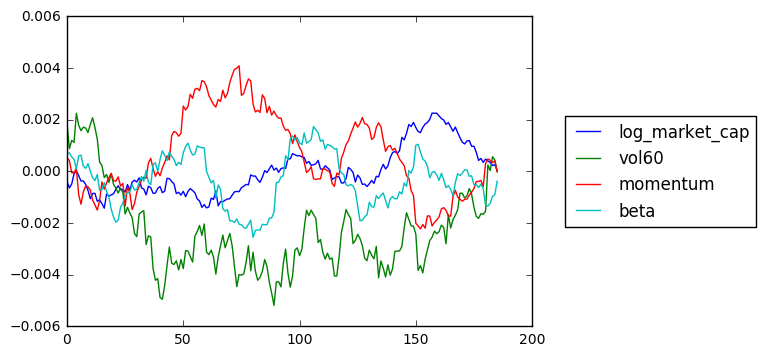

In [4]:
fr_series = np.stack(fr['factor_returns'] for fr in spcalc.all_factor_returns.values())
window = 30
ck = np.ones((window,)) / window
for c in range(4):
    fr_series[:,c] = np.convolve(ck, fr_series[:,c])[window-1:]
    plt.plot(fr_series[:,c], label=spcalc.all_factor_names[c])
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

In [5]:
bt.calc_pa(silent=False)

CAGR :	 0.415717554426
Volatility :	 0.402654609874
Sharpe :	 0.863361550167
Max_Drawdown :	 0.558113638813
Drawdown_Length :	 0


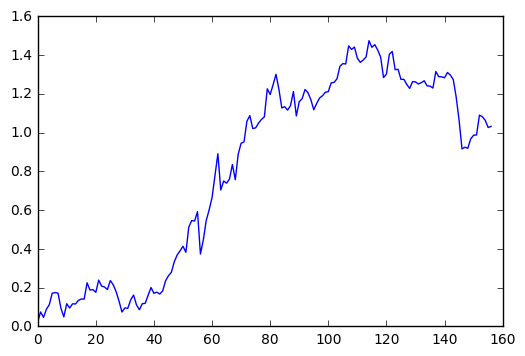

In [6]:
plt.plot(np.cumsum(pnl_lst['pnl']))
plt.show()

In [8]:
tstamp = str(datetime.now())
bt.pnl_lst.to_csv('output/pnl_final_pre_%s.csv' % tstamp)

In [9]:
ptfl_lst = pd.concat(bt.ptfl_lst)
pp = pd.pivot_table(ptfl_lst, values='weight', columns='ticker', index='date')
pp.to_csv('output/portfolio_table_%s.csv' % tstamp)